# Classifier using LSTM layers

## 1. Importing Libraries

In [32]:
import torch

import pennylane as qml
import numpy as np
import pandas as pd

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 10

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [33]:
import os


def get_categories_from_data(folder, n=None):
    categories = []
    files = os.listdir(folder)

    for file in files:
        fname = file[16:-7]
        if len(fname) > 0:
            categories.append(fname)

    if n is None:
        return categories
    
    return categories[:n]

classes = get_categories_from_data(data_folder)
class_id = dict(zip(classes, range(len(classes))))


camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'camera': 0, 'cell phone': 1}

In [34]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes
    
    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)
    
    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]
    
    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0
    
    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]
    
    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)

# TODO: Limitar dataset
resized_cellphone_drawings = resized_cellphone_drawings[:10000]
resized_camera_drawings = resized_camera_drawings[:10000]

resized_camera_drawings.shape, resized_cellphone_drawings.shape

((10000, 95, 3), (10000, 95, 3))

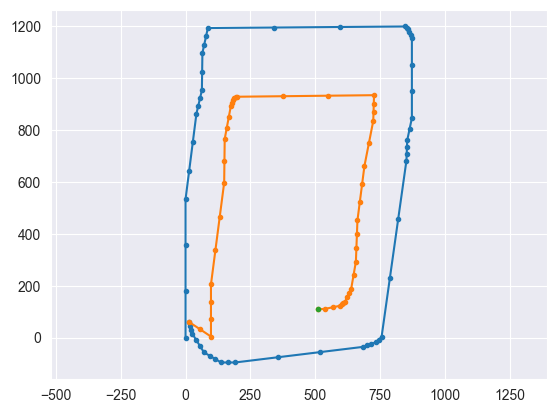

In [35]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()
    
    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()
    
draw_strokes(resized_cellphone_drawings[0])

In [36]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras and cellphones.
    
    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    test_size (float): The proportion of the dataset to include in the test split.
    
    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    # Labels for the datasets
    camera_labels = np.zeros(camera_drawings.shape[0])
    cellphone_labels = np.ones(cellphone_drawings.shape[0])
    
    # Combine the drawings from both categories
    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels], axis=0)
    
    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, test_size=0.2)

In [37]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16000, 95, 3), (16000,), (4000, 95, 3), (4000,))

In [38]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.
    
    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    # Convert numpy arrays to TensorFlow tensors
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long))
    
    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

# Setup DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
print(len(train_loader))
print(len(test_loader))

1600
400


## 3. Model Building

### 3.1. Quantum Layer

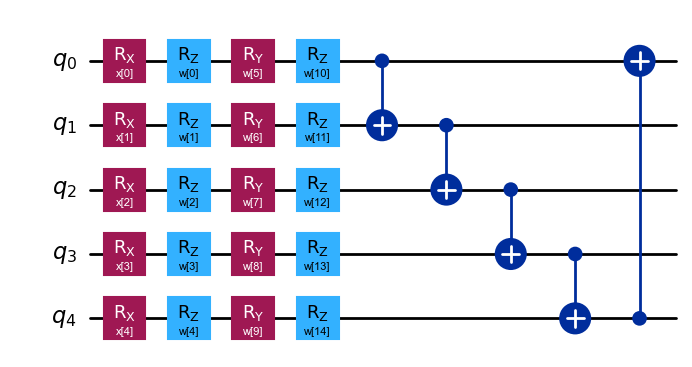

In [40]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit.quantum_info import SparsePauliOp


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)
    
    for i in range(n):
        circuit.rx(features[i], i)
    
    return circuit
    
def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)
    
    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)
        
    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)
        
    for i in range(n):
        circuit.rz(weights[2*n+i], i)
        
    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)
    
    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)
    
    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        observables=[SparsePauliOp(['YIIII']), SparsePauliOp(['IYIII']), SparsePauliOp(['IIYII']), SparsePauliOp(['IIIYI']), SparsePauliOp(['IIIIY'])], # Pauli('Y' * n),
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        
        # Dense layers
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 128)
        
        # Quantum layer
        self.fc3 = nn.Linear(128, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])
        
        # Dense layer for classification
        self.fc4 = nn.Linear(n_qubits, num_categories)
        
        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        
        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        
        # Flatten the output for dense layer
        x = torch.flatten(x, 1)
        
        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)
        
        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [42]:
checkpoint_filepath = 'models/quantum_lstm/best_model_weights.pth'

In [44]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples

# Training loop
best_accuracy = 0
loss_list = [] 

for epoch in range(EPOCHS):
    model.train() 
    total_loss = []
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        
    # Evaluate the model on the validation data after each epoch
    val_accuracy = evaluate(model, test_loader)
    loss_list.append(sum(total_loss) / len(train_loader))
    print(f'Epoch {epoch + 1}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}')
    
    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 1600/1600 [1:00:21<00:00,  2.26s/it]


Epoch 1, Loss: 0.6931471824645996, Validation Accuracy: 0.50475


100%|██████████| 1600/1600 [1:00:24<00:00,  2.27s/it]


Epoch 2, Loss: 0.6931471824645996, Validation Accuracy: 0.50475


 48%|████▊     | 776/1600 [29:06<30:54,  2.25s/it]


KeyboardInterrupt: 

## 5. Model Evaluation

In [ ]:
nn = HybridNN(input_shape, num_categories=2, fname=checkpoint_filepath)

In [ ]:
INDEX = 0

out = nn.predict(X_test[:2500][INDEX])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])